<div style="float:left">
    <h1 style="width:450px">Live Coding 8: </h1>
    <h2 style="width:450px">Visualisation and Linked Data</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Live-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

## Task 1. Load Chicago Data

Load the Census Tracts.

Inspect the data

Ensure it is suitable for plotting

In [2]:
tracts = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Census_Tracts.gpkg?raw=true')
print(tracts.columns.values)
print(tracts.shape)

['STATEFP10' 'COUNTYFP10' 'TRACTCE10' 'GEOID10' 'NAME10' 'NAMELSAD10'
 'COMMAREA' 'COMMAREA_N' 'NOTES' 'geometry']
(801, 10)


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

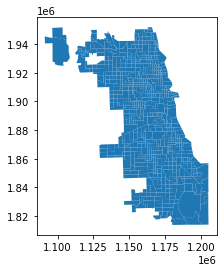

In [3]:
tracts.plot()

In [4]:
len(tracts.NAME10.unique())

801

<AxesSubplot:>

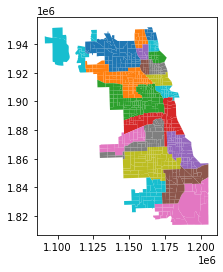

In [5]:
#these are the districts of Chicago
tracts.plot(column='COMMAREA')

Load the Crime Data.

In [6]:
df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/2019-Crime.csv.gz?raw=true', compression='gzip')
df.shape

(260025, 22)

Convert to a geography.

In [7]:
#Remove our nas
df.drop(index=df[df.Latitude.isna()].index, inplace=True)
df.drop(index=df[df.Longitude.isna()].index, inplace=True)
df.shape

(258853, 22)

In [8]:
#Lets look over our columns good practice!!!
df.columns.values

array(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic',
       'Beat', 'District', 'Ward', 'Community Area', 'FBI Code',
       'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude',
       'Longitude', 'Location'], dtype=object)

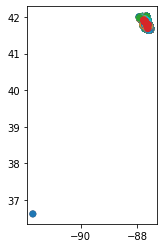

In [9]:
#From here lets create a geodataframe

crimes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude, crs='epsg:4326'))
crimes.plot(column='Primary Type');

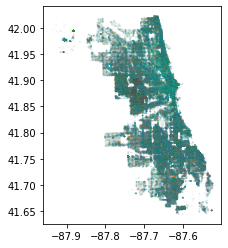

In [10]:
#Ok here we can see that we have a one or a few outliers in our dataset so lets go and remove them 
crimes.drop(index=crimes[crimes.Longitude < -89].index, inplace=True)
crimes.plot(column='Primary Type', markersize=0.5, alpha=0.05);

#### Join Crimes to Tracts using a Spatial Join

In [11]:
#ok so lets look at the unique values types of crime in this case
crimes['Primary Type'].unique()
#Lets take this dataset with a pinch of salt
#remember our old lessons from data feminism

array(['OFFENSE INVOLVING CHILDREN', 'ROBBERY', 'MOTOR VEHICLE THEFT',
       'OTHER OFFENSE', 'DECEPTIVE PRACTICE', 'BATTERY', 'NARCOTICS',
       'KIDNAPPING', 'CRIMINAL SEXUAL ASSAULT', 'ASSAULT', 'SEX OFFENSE',
       'BURGLARY', 'THEFT', 'WEAPONS VIOLATION', 'HOMICIDE',
       'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'INTIMIDATION', 'ARSON',
       'OBSCENITY', 'LIQUOR LAW VIOLATION', 'HUMAN TRAFFICKING',
       'STALKING', 'PUBLIC PEACE VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'CRIM SEXUAL ASSAULT',
       'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION',
       'PROSTITUTION', 'GAMBLING', 'OTHER NARCOTIC VIOLATION',
       'NON-CRIMINAL'], dtype=object)

In [12]:
#Crimes to crs what are we doing here.
#Transform geometries to a new coordinate reference system.
#so we convert the "Coordinate Reference Systems" 
crimes = crimes.to_crs(tracts.crs)

Here's our first spatial join. By default it will be an _inner_ join.

In [13]:
#Lets look at one of crime catogories use the colummn names above to chose a crime for plotting
ptype='PROSTITUTION'
tract_crimes = gpd.sjoin(crimes[crimes['Primary Type']==ptype], tracts, op='within')

In [14]:
tract_crimes.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,index_right,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,COMMAREA,COMMAREA_N,NOTES
8989,11934142,JC562348,12/27/2019 06:10:00 PM,001XX S KENTON AVE,1506,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,False,...,68,17,031,252202,17031252202,2522.02,Census Tract 2522.02,25,25,None
9351,11934044,JC562316,12/27/2019 06:35:00 PM,0000X S KENTON AVE,1506,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,False,...,68,17,031,252202,17031252202,2522.02,Census Tract 2522.02,25,25,None
10143,11932996,JC552851,12/19/2019 11:38:00 AM,001XX S KENTON AVE,1506,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,False,...,68,17,031,252202,17031252202,2522.02,Census Tract 2522.02,25,25,None


In [15]:
#after we have looked at the head of the our data lets look at our columns
print(tract_crimes.columns.values)

['ID' 'Case Number' 'Date' 'Block' 'IUCR' 'Primary Type' 'Description'
 'Location Description' 'Arrest' 'Domestic' 'Beat' 'District' 'Ward'
 'Community Area' 'FBI Code' 'X Coordinate' 'Y Coordinate' 'Year'
 'Updated On' 'Latitude' 'Longitude' 'Location' 'geometry' 'index_right'
 'STATEFP10' 'COUNTYFP10' 'TRACTCE10' 'GEOID10' 'NAME10' 'NAMELSAD10'
 'COMMAREA' 'COMMAREA_N' 'NOTES']


<AxesSubplot:>

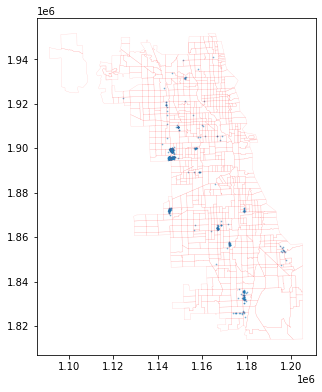

In [16]:
#Lets plot this data
ax = tract_crimes.plot(markersize=0.5, alpha=0.5, figsize=(5,10))
#Talk through all the inputs to the plot here
tracts.plot(ax=ax, edgecolor='r', linewidth=0.25, facecolor='none', alpha=0.25)

#### Tidy Up
Lets remove all the data that we don't require for the plot

```python
['ID' 'Case Number' 'Date' 'Block' 'IUCR' 'Primary Type' 'Description'
 'Location Description' 'Arrest' 'Domestic' 'Beat' 'District' 'Ward'
 'Community Area' 'FBI Code' 'X Coordinate' 'Y Coordinate' 'Year'
 'Updated On' 'Latitude' 'Longitude' 'Location' 'geometry' 'index_right'
 'STATEFP10' 'COUNTYFP10' 'TRACTCE10' 'GEOID10' 'NAME10' 'NAMELSAD10'
 'COMMAREA' 'COMMAREA_N' 'NOTES']
```

In [17]:
to_drop = ['ID','Case Number','Date','Block','IUCR','Domestic','FBI Code','X Coordinate',
           'Y Coordinate','Year','Updated On','Latitude','Longitude','Location','index_right',
           'COMMAREA_N','NOTES']
tract_crimes.drop(columns=to_drop, inplace=True)
print(tract_crimes.shape)

(680, 16)


In [18]:
tract_crimes

,Primary Type,Description,Location Description,Arrest,Beat,District,Ward,Community Area,geometry,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,COMMAREA
8989,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,1113,11,28.0,25,POINT (1145676.000 1899109.000),17,031,252202,17031252202,2522.02,Census Tract 2522.02,25
9351,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,1113,11,28.0,25,POINT (1145662.000 1899532.000),17,031,252202,17031252202,2522.02,Census Tract 2522.02,25
10143,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,1113,11,28.0,25,POINT (1145677.000 1899086.000),17,031,252202,17031252202,2522.02,Census Tract 2522.02,25
24695,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,1113,11,28.0,25,POINT (1145672.000 1899242.000),17,031,252202,17031252202,2522.02,Census Tract 2522.02,25
26157,PROSTITUTION,SOLICIT ON PUBLIC WAY,STREET,True,1113,11,28.0,25,POINT (1145676.000 1899109.000),17,031,252202,17031252202,2522.02,Census Tract 2522.02,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256223,PROSTITUTION,OTHER PROSTITUTION OFFENSE,COMMERCIAL / BUSINESS OFFICE,True,1213,12,1.0,24,POINT (1166399.000 1905446.000),17,031,243300,17031243300,2433,Census Tract 2433,24
240602,PROSTITUTION,OTHER PROSTITUTION OFFENSE,RESIDENCE,True,1631,16,38.0,17,POINT (1124454.000 1922675.000),17,031,170700,17031170700,1707,Census Tract 1707,17
248020,PROSTITUTION,SOLICIT FOR BUSINESS,OTHER,True,1211,12,26.0,24,POINT (1159137.000 1905238.000),17,031,242500,17031242500,2425,Census Tract 2425,24
251066,PROSTITUTION,OTHER PROSTITUTION OFFENSE,COMMERCIAL / BUSINESS OFFICE,True,1212,12,2.0,24,POINT (1161271.000 1905293.000),17,031,242400,17031242400,2424,Census Tract 2424,24


#### And Save

In [19]:
#this will only work if the path is exists remember
tract_crimes.to_file(os.path.join('data','geo',f"Tract_Crimes-{ptype}.gpkg"), driver='GPKG')

## Task 2. Grouping Data

### Grouping by Tract

Lets group ourdata by our smallest spatial unit. In this case the census tract

In [20]:
tc_grdf = tract_crimes.groupby('NAME10').agg(np.sum)

In [21]:
tc_grdf.sample(5)

,Arrest,Beat,District,Ward,Community Area
NAME10,,,,,
6701,5,3565,35,80.0,335
8352,1,815,8,14.0,56
2306,24,60818,600,646.0,552
2502,1,2533,25,37.0,25
4602,1,423,4,7.0,46


Does that make sense??? know the metadata

In [22]:
print(tract_crimes[tract_crimes.NAME10=='1502'].shape)
print(tract_crimes[tract_crimes.NAME10=='2522.02'].shape)

(1, 16)
(54, 16)


In [23]:
tc_grdf.Arrest.sample(5, random_state=42)

NAME10
1502    1
8311    1
2434    1
1301    1
3007    1
Name: Arrest, dtype: int64

In [24]:
print(f"Mean arrests per Census Tract: {tc_grdf.Arrest.mean():.0f}")
print(f"Median arrests per Census Tract: {tc_grdf.Arrest.median():.0f}")

Mean arrests per Census Tract: 9
Median arrests per Census Tract: 1


#### A Basic Boxplot

See if you can create a basic boxplot arrests by cencus tracts, and then set the y-limits to 0-30 (arrests/tract).

(0.0, 30.0)

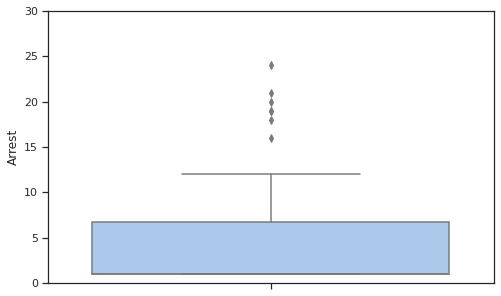

In [25]:
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f,ax = plt.subplots(figsize=(8,5))
sns.boxplot(y=tc_grdf.Arrest)
ax.set_ylim([0,30])

Let's look at the distribution a bit differently:

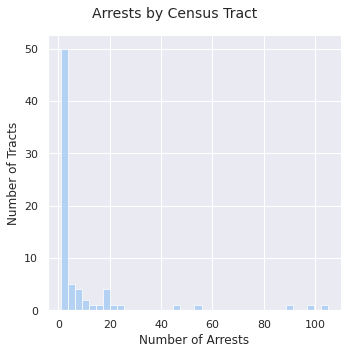

In [26]:
sns.set_style('darkgrid')
ax = sns.displot(tc_grdf.Arrest)
ax.set(xlabel='Number of Arrests', ylabel='Number of Tracts')
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().suptitle('Arrests by Census Tract', fontsize=14);

Join this back to a geography!

In [27]:
print(tracts.columns.values)
print(tc_grdf.columns.values)

['STATEFP10' 'COUNTYFP10' 'TRACTCE10' 'GEOID10' 'NAME10' 'NAMELSAD10'
 'COMMAREA' 'COMMAREA_N' 'NOTES' 'geometry']
['Arrest' 'Beat' 'District' 'Ward' 'Community Area']


In [28]:
tcgr_gdf = pd.merge(tracts, tc_grdf, left_on='NAME10', right_index=True)

In [29]:
tcgr_gdf.head(3)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,COMMAREA,COMMAREA_N,NOTES,geometry,Arrest,Beat,District,Ward,Community Area
21,17,031,834800,17031834800,8348,Census Tract 8348,68,68,None,"POLYGON ((1170721.790 1863187.997, 1170721.047...",1,712,7,16.0,68
28,17,031,040202,17031040202,402.02,Census Tract 402.02,4,4,None,"POLYGON ((1158746.754 1934451.249, 1158718.477...",1,2011,20,40.0,4
50,17,031,837000,17031837000,8370,Census Tract 8370,27,27,None,"POLYGON ((1157752.239 1899069.031, 1157754.217...",11,13442,132,297.0,297


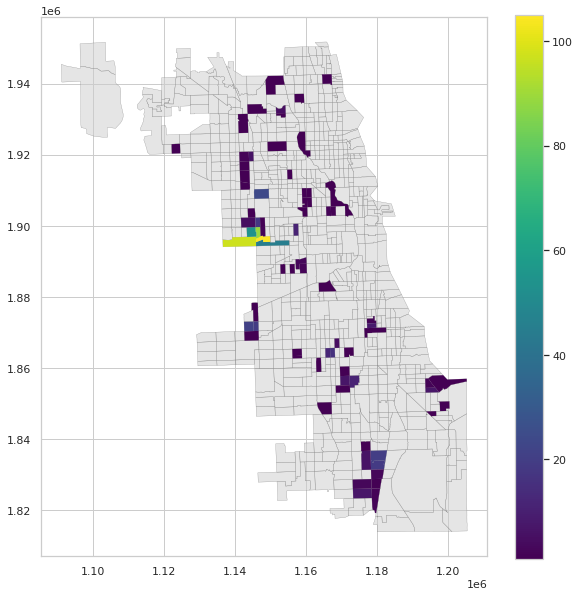

In [30]:
sns.set_style('whitegrid')
ax = tracts.plot(facecolor=(0.8, 0.8, 0.8, 0.5), edgecolor='gray', linewidth=0.25, figsize=(10,10))
tcgr_gdf.plot(ax=ax, column='Arrest', cmap='viridis', edgecolor='none', legend=True);

### Task 3
Create at Atlas-Type Output

We're now going to emulate a _bit_ of QGIS' Atlas function by creating two subplots and then adding a _third_ plot afterwards that shows where the borough is.

Lets look at the workflows we were working on earlier



In [31]:
crimes.columns.values

array(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic',
       'Beat', 'District', 'Ward', 'Community Area', 'FBI Code',
       'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude',
       'Longitude', 'Location', 'geometry'], dtype=object)

In [32]:
grp_crimes = crimes[['Community Area','Primary Type','Arrest']].groupby(['Community Area','Primary Type']).agg(np.sum).reset_index()

In [33]:
grp_crimes

,Community Area,Primary Type,Arrest
0,1,ARSON,0
1,1,ASSAULT,45
2,1,BATTERY,146
3,1,BURGLARY,19
4,1,CRIM SEXUAL ASSAULT,0
...,...,...,...
1902,77,ROBBERY,8
1903,77,SEX OFFENSE,4
1904,77,STALKING,0
1905,77,THEFT,80


### Task 3.1 
Using Seaborn to explore our data

Here I will run through a quick example of how I often go about building plots

Lets take a closer look at our crime data. I will do this creating a box plot looking at crimes by community area 
https://seaborn.pydata.org/examples/horizontal_boxplot.html

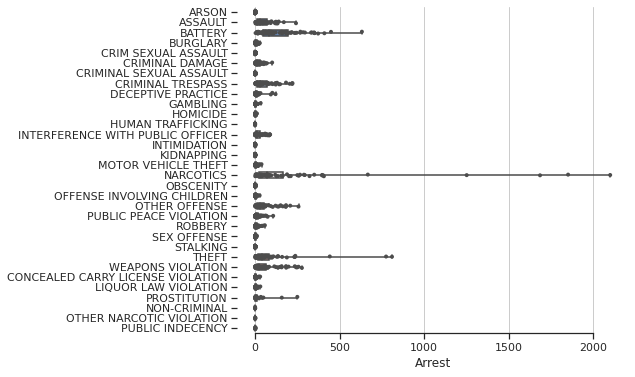

In [35]:
#bring in the example from seaborn here and adapt it to fix our data

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))


# Plot the orbital period with horizontal boxes
sns.boxplot(x="Arrest", y="Primary Type", data=grp_crimes,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="Arrest", y="Primary Type", data=grp_crimes,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)



In [36]:
#lets review our spatial dataset 
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   801 non-null    object  
 1   COUNTYFP10  801 non-null    object  
 2   TRACTCE10   801 non-null    object  
 3   GEOID10     801 non-null    object  
 4   NAME10      801 non-null    object  
 5   NAMELSAD10  801 non-null    object  
 6   COMMAREA    801 non-null    object  
 7   COMMAREA_N  801 non-null    int64   
 8   NOTES       12 non-null     object  
 9   geometry    801 non-null    geometry
dtypes: geometry(1), int64(1), object(8)
memory usage: 62.7+ KB


<AxesSubplot:>

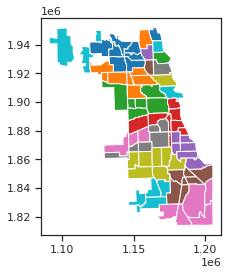

In [37]:
t1 = tracts.dissolve(by='COMMAREA').reset_index()
t1.columns.values
t1.plot(column='COMMAREA')

In [38]:
t1.sample(3)

,COMMAREA,geometry,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,COMMAREA_N,NOTES
41,47,"POLYGON ((1183209.725 1842507.146, 1183208.337...",17,031,470100,17031470100,4701,Census Tract 4701,47,None
50,55,"POLYGON ((1195724.557 1814029.374, 1195474.585...",17,031,550200,17031550200,5502,Census Tract 5502,55,None
37,43,"POLYGON ((1197290.400 1853155.418, 1197263.116...",17,031,430102,17031430102,4301.02,Census Tract 4301.02,43,None


In [39]:
tgrp = pd.merge(grp_crimes, t1, how='left', left_on='Community Area', right_on='COMMAREA_N')
print(tgrp.columns.values)
tgrp = tgrp.set_geometry('geometry')

['Community Area' 'Primary Type' 'Arrest' 'COMMAREA' 'geometry'
 'STATEFP10' 'COUNTYFP10' 'TRACTCE10' 'GEOID10' 'NAME10' 'NAMELSAD10'
 'COMMAREA_N' 'NOTES']


<AxesSubplot:>

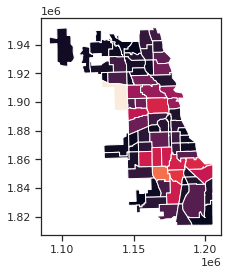

In [40]:
tgrp[tgrp['Primary Type']=='ASSAULT'].plot(column='Arrest')

<AxesSubplot:>

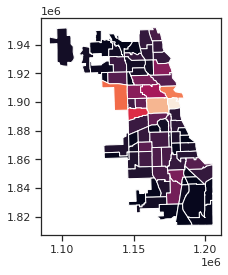

In [41]:
tgrp[tgrp['Primary Type']=='ROBBERY'].plot(column='Arrest')

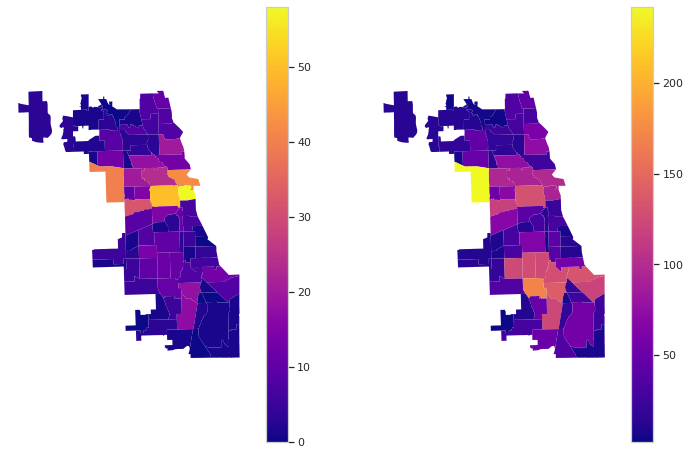

In [42]:
f,axes = plt.subplots(1,2,figsize=(12,8))

sns.set_style('whitegrid')
tgrp[tgrp['Primary Type']=='ROBBERY'].plot(ax=axes[0], column='Arrest', cmap='plasma', edgecolor='none', legend=True)
tgrp[tgrp['Primary Type']=='ASSAULT'].plot(ax=axes[1], column='Arrest', cmap='plasma', edgecolor='none', legend=True);

for ax in axes:
    ax.axis('off')

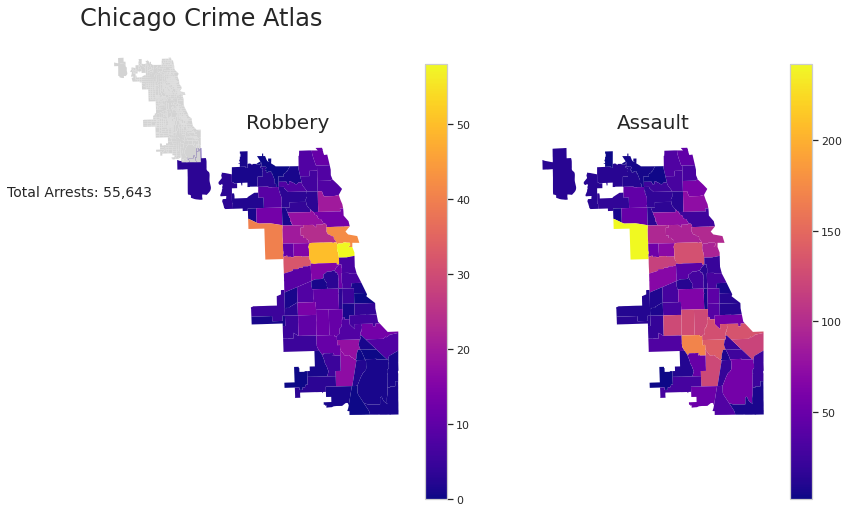

In [43]:
f,axes = plt.subplots(1,2,figsize=(12,8))

plt1 = 'ROBBERY'
plt2 = 'ASSAULT'

tgrp[tgrp['Primary Type']==plt1].plot(ax=axes[0], column='Arrest', cmap='plasma', edgecolor='none', legend=True)
tgrp[tgrp['Primary Type']==plt2].plot(ax=axes[1], column='Arrest', cmap='plasma', edgecolor='none', legend=True);

for ax in axes:
    ax.axis('off')

ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
tracts.plot(facecolor='lightgrey', edgecolor='none', ax=ax2)
ax2.axis('off')

# Note -- calling this an atlas of crime would be *seriously* 
# misleading because it's only a record of crimes that resulted
# in police action of some sort

f.suptitle('Chicago Crime Atlas', x=0.025, ha='left', size=24)
axes[0].set_title(plt1.capitalize(), size=20)
axes[1].set_title(plt2.capitalize(), size=20)

plt.figtext(x=0.025, y=0.65, ha='center', s=f"Total Arrests: {tgrp.Arrest.sum():,.0f}", size=14);